In [1]:
from models import FieldMLP, FieldAttention
import importlib
import utils
importlib.reload(utils)
from utils import *

pio.renderers.default = "browser"

In [2]:
# Step 1: Build model
model = FieldMLP(out_dim=2, hidden=128, depth=2).to(device)   # NOTE: 2 outputs = u,v

# Step 2: Wrap in TuringSDF (with PDE params)
turing_sdf = TuringSDF(
    model=model, 
    domain=(-1,1), 
    device=device,
    Du=2.4e-5, Dv=1.2e-5, alpha=0.028, beta=0.057
)

In [3]:

# Step 3: Use a custom constraint wrapper that calls residuals
turing_constraints = Constraints()

@turing_constraints.add(1.0, True)
def pde_loss(field, coords, residuals):
    Ru, Rv, u, v = residuals if (residuals != None) else turing_sdf.residuals(coords)
    return (Ru**2).mean() + (Rv**2).mean()

@turing_constraints.add(0.0001, True)
def nontrivial(field, coords, residuals):
    Ru, Rv, u, v = residuals if (residuals != None) else turing_sdf.residuals(coords)
    grad_energy = (u.pow(2).mean() + v.pow(2).mean())
    return -grad_energy   # encourages structure

In [4]:

# Step 4: Lightning trainer
wandb_logger = WandbLogger(project="ginn2d", name="turing_run_retest")
lit = ConstraintTrainer(
    turing_sdf, 
    constraints=turing_constraints, 
    lr=1e-3, 
    n_points=2048, 
    domain=[-1,1], 
    seed=42
)

Seed set to 42


In [5]:

trainer = pl.Trainer(
    max_epochs=100,    # needs longer than geometry
    accelerator="auto",
    precision="bf16-mixed" if torch.cuda.is_available() else "32-true",
    logger=wandb_logger,
    gradient_clip_val=1.0,
    log_every_n_steps=10,
)

trainer.fit(lit)


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: navrajansk (navrajansk-johannes-kepler-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | FieldMLP | 642    | train
-------------------------------------------
642       Trainable params
0         Non-trainable params
642       Total params
0.003     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
C:\Users\navra\anaconda3\envs\GINN\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 18.13it/s, v_num=ab74, loss_step=-0.000115, pde_loss_step=1.68e-5, nontrivial_step=-1.31, loss_epoch=-0.000115, pde_loss_epoch=1.68e-5, nontrivial_epoch=-1.31] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 17.58it/s, v_num=ab74, loss_step=-0.000115, pde_loss_step=1.68e-5, nontrivial_step=-1.31, loss_epoch=-0.000115, pde_loss_epoch=1.68e-5, nontrivial_epoch=-1.31]


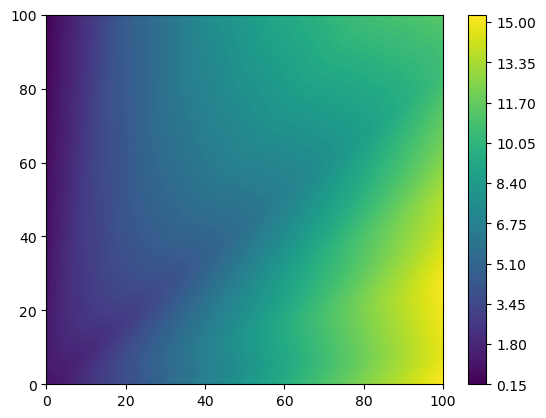

In [14]:
turing_sdf.plot_field(domain=(0,100), preprocess=lambda x: x[:, 0], newN=1000)